In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, stddev, min, max, corr
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#### Initialiser Spark Session

In [2]:
spark = SparkSession.builder.appName("HIGGSClassification").getOrCreate()

25/03/12 20:41:33 WARN Utils: Your hostname, MacBook-Air-de-Tourgi.local resolves to a loopback address: 127.0.0.1; using 192.168.10.125 instead (on interface en0)
25/03/12 20:41:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/12 20:41:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Charger les données

In [4]:
df_train = spark.read.csv("/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Train.csv", header=False, inferSchema=True)
df_test = spark.read.csv("/Users/tourgismacbook/Downloads/etc/Projet-Higgs/HIGGS-Test.csv", header=False, inferSchema=True)

#### Afficher le schéma du dataset (train)


In [7]:
df_train.printSchema()

root
 |-- _c0: double (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: double (nullable = true)
 |-- _c15: double (nullable = true)
 |-- _c16: double (nullable = true)
 |-- _c17: double (nullable = true)
 |-- _c18: double (nullable = true)
 |-- _c19: double (nullable = true)
 |-- _c20: double (nullable = true)
 |-- _c21: double (nullable = true)
 |-- _c22: double (nullable = true)
 |-- _c23: double (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: double (nullable = tru

#### Renommer la première colonne en "label" et les autres en "feature_X"


In [12]:
columns = ["label"] + [f"feature_{i}" for i in range (1, df_train.columns.__len__())]
df_train = df_train.toDF(*columns)

#### Affichage des 5 premieres lignes de notre Dataframe

In [13]:
df_train.show(5)

+-----+------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|label|         feature_1|          feature_2|          feature_3|         feature_4|          feature_5|         feature_6|           feature_7|          feature_8|         feature_9|        feature_10|         feature_11|         feature_12|        feature_13|        feature_14|          feature_15|         feature_16|       feature_17|         feature_18|          feature_19|          feature_20|       feature_21|        feature_22|       

## Analyse de données

#### Analyse univariée : Statistiques descriptives


In [15]:
summary_stats = df_train.describe().toPandas()
print("Statistiques Descriptives:")
print(summary_stats)

Statistiques Descriptives:
  summary               label           feature_1             feature_2  \
0   count             1000000             1000000               1000000   
1    mean            0.529673  0.9915919662907422  4.885219597013566E-4   
2  stddev  0.4991189860051024  0.5650989927094415     1.008275657787953   
3     min                 0.0  0.2746966481208801    -2.434976100921631   
4     max                 1.0    8.71178150177002    2.4348678588867188   

               feature_3             feature_4              feature_5  \
0                1000000               1000000                1000000   
1  -9.528433616999537E-4    0.9981498799093321  -5.725853022988021E-4   
2      1.005810231253231    0.5991514453524263      1.006808266200698   
3    -1.7425082921981812  6.259872461669147E-4    -1.7439435720443726   
4     1.7432359457015991      9.90092945098877     1.7432570457458496   

             feature_6              feature_7             feature_8  ...  \
0      

#### Histogrammes des principales features

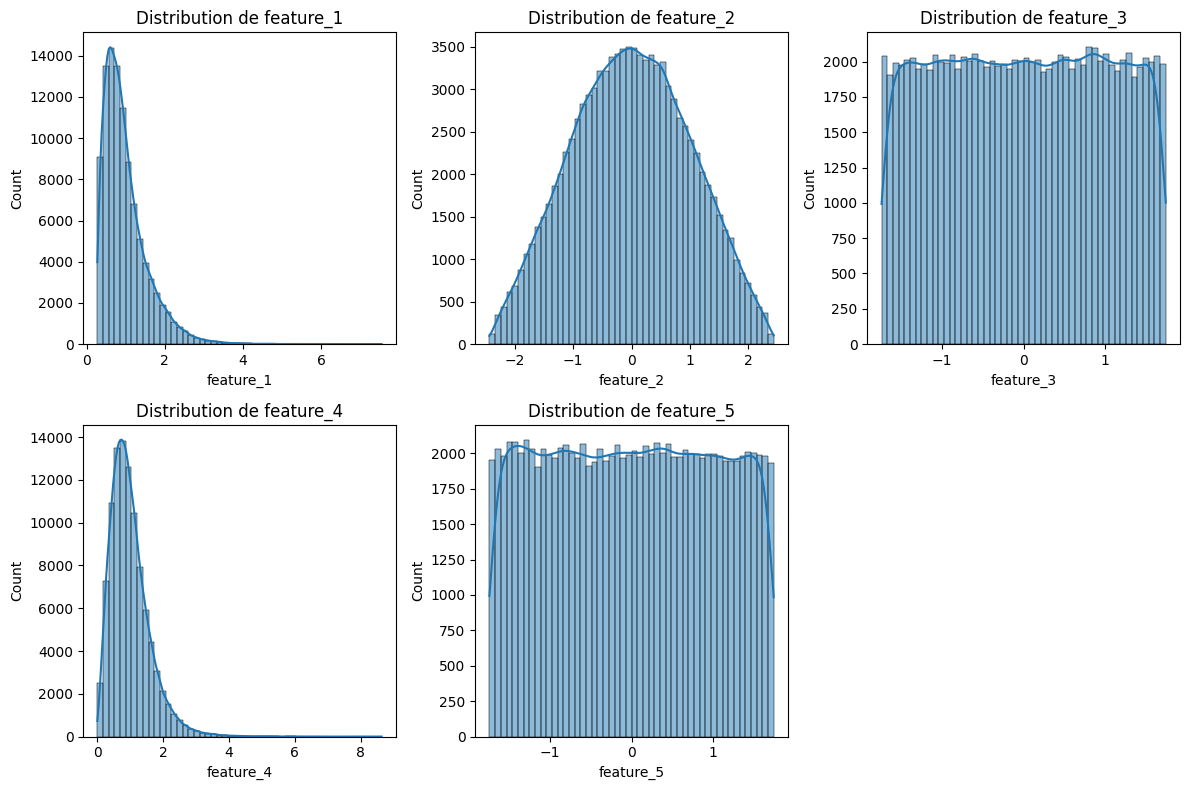

In [16]:
num_features = 5  # Nombre de features à visualiser
sample_df = df_train.select(["feature_1", "feature_2", "feature_3", "feature_4", "feature_5"]).sample(fraction=0.1).toPandas()

plt.figure(figsize=(12, 8))
for i, col_name in enumerate(sample_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(sample_df[col_name], bins=50, kde=True)
    plt.title(f"Distribution de {col_name}")
plt.tight_layout()
plt.show()

#### Analyse bivariée : Corrélations entre les variables


In [17]:
correlations = []
feature_cols = [f"feature_{i}" for i in range(1, 29)]

for feature in feature_cols:
    corr_value = df_train.stat.corr("label", feature)
    correlations.append((feature, corr_value))

#### Convertir en DataFrame Pandas et afficher les corrélations


In [20]:
correlation_df = pd.DataFrame(correlations, columns=["Feature", "Correlation with Label"])
print("Corrélations avec la variable cible:")
print(correlation_df)

Corrélations avec la variable cible:
       Feature  Correlation with Label
0    feature_1               -0.047785
1    feature_2               -0.000113
2    feature_3                0.001095
3    feature_4               -0.099515
4    feature_5               -0.001160
5    feature_6                0.055723
6    feature_7               -0.001360
7    feature_8               -0.000361
8    feature_9               -0.010886
9   feature_10                0.021665
10  feature_11                0.001252
11  feature_12               -0.002438
12  feature_13               -0.048911
13  feature_14                0.014582
14  feature_15                0.000230
15  feature_16                0.000483
16  feature_17               -0.023844
17  feature_18                0.036789
18  feature_19               -0.000713
19  feature_20               -0.000306
20  feature_21                0.014416
21  feature_22                0.012307
22  feature_23                0.025381
23  feature_24             

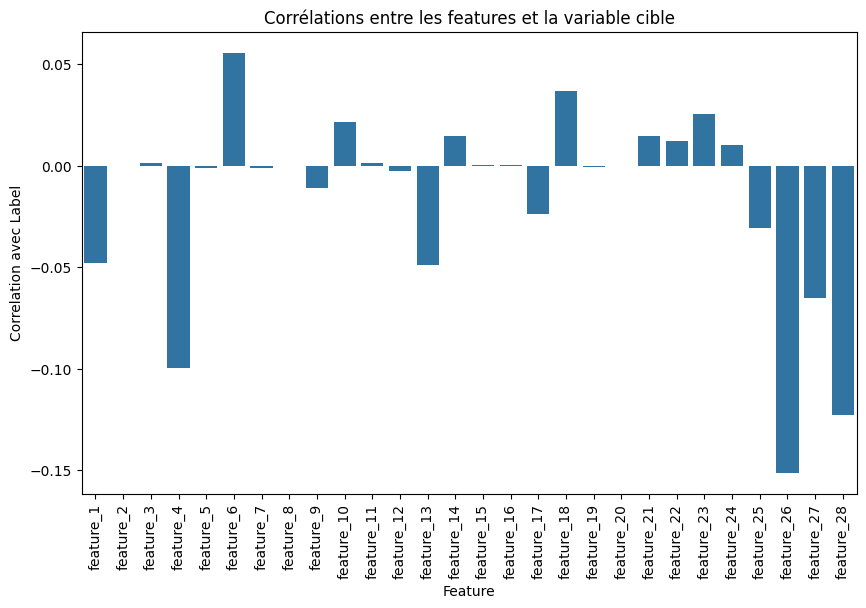

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Feature", y="Correlation with Label", data=correlation_df)
plt.xticks(rotation=90)
plt.title("Corrélations entre les features et la variable cible")
plt.xlabel("Feature")
plt.ylabel("Correlation avec Label")
plt.show()


#### Heatmap des corrélations entre features


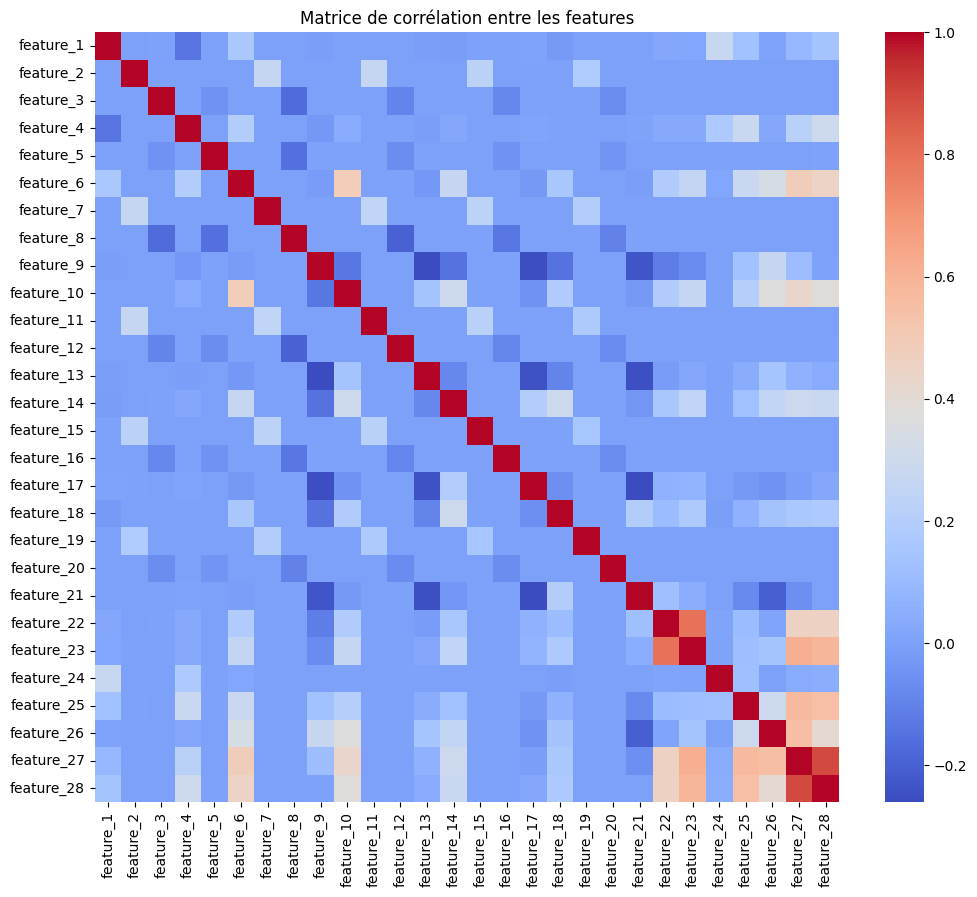

In [22]:
corr_matrix = df_train.select(feature_cols).toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matrice de corrélation entre les features")
plt.show()

# Entrainement de données sur 3 modéles

#### Supprimer les colonnes au-delà des 21 premières features


In [ ]:
df_train = df_train.select([df_train.columns[i] for i in range(22)])
df_test = df_test.select([df_test.columns[i] for i in range(22)])

#### Renommer la première colonne en "label" et les autres en "feature_X"


In [32]:
columns = ["label"] + [f"feature_{i}" for i in range(1, 22)]  # Garder uniquement les 21 premières features
df_train = df_train.toDF(*columns)
df_test = df_test.toDF(*columns)

#### Transformer les features en un vecteur de caractéristiques


In [33]:
feature_cols = [f"feature_{i}" for i in range(1, 22)]  # Garder uniquement les 21 premières features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_train = assembler.transform(df_train).select("label", "features")
df_test = assembler.transform(df_test).select("label", "features")

#### Définir les modèles


In [34]:
models = {
    "LogisticRegression": LogisticRegression(featuresCol="features", labelCol="label"),
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10),
    "GBT": GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)
}

#### Définir l'évaluateur


In [35]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

#### Entraînement avec Cross-Validation et tuning des hyperparamètres


In [36]:
cv_results = {}
for name, model in models.items():
    paramGrid = ParamGridBuilder()
    if name == "LogisticRegression":
        paramGrid = paramGrid.addGrid(model.regParam, [0.01, 0.1, 1.0])
    elif name == "RandomForest":
        paramGrid = paramGrid.addGrid(model.numTrees, [10, 20, 50])
    elif name == "GBT":
        paramGrid = paramGrid.addGrid(model.maxIter, [10, 20, 50])
    paramGrid = paramGrid.build()
    
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=evaluator,
                              numFolds=3)
    
    cv_model = crossval.fit(df_train)
    best_model = cv_model.bestModel
    auc = evaluator.evaluate(best_model.transform(df_test))
    cv_results[name] = auc
    print(f"{name}: Best AUC = {auc}")

25/03/12 21:58:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/12 21:58:15 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


LogisticRegression: Best AUC = 0.5958508548183324


25/03/12 22:00:21 WARN MemoryStore: Not enough space to cache rdd_2177_1 in memory! (computed 45.9 MiB so far)
25/03/12 22:00:21 WARN MemoryStore: Not enough space to cache rdd_2177_2 in memory! (computed 45.9 MiB so far)
25/03/12 22:00:21 WARN MemoryStore: Not enough space to cache rdd_2177_3 in memory! (computed 45.9 MiB so far)
25/03/12 22:00:21 WARN BlockManager: Persisting block rdd_2177_3 to disk instead.
25/03/12 22:00:21 WARN BlockManager: Persisting block rdd_2177_2 to disk instead.
25/03/12 22:00:21 WARN BlockManager: Persisting block rdd_2177_1 to disk instead.


RandomForest: Best AUC = 0.641226241811007


GBT: Best AUC = 0.6952390528874245


#### les résultats des modèles


In [37]:
results_df = pd.DataFrame(list(cv_results.items()), columns=["Model", "AUC Score"])
print(results_df)

                Model  AUC Score
0  LogisticRegression   0.595851
1        RandomForest   0.641226
2                 GBT   0.695239


#### Graphe comparatif des performances


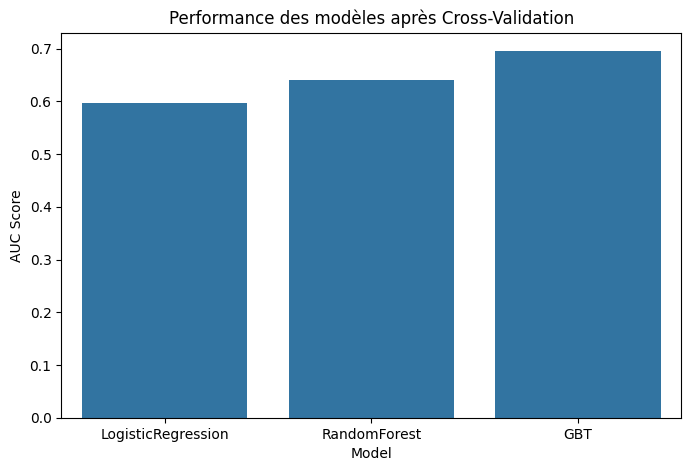

In [38]:
plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="AUC Score", data=results_df)
plt.title("Performance des modèles après Cross-Validation")
plt.ylabel("AUC Score")
plt.show()
